In [3]:
%pip install -q -U pip
%pip install -q -U networkx
%pip install -q -U matplotlib
%pip install -q -U numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import collections
import numpy as np

from custommodels.Pickle import pickle

In [5]:
#import data from file
path = "../data/loc-brightkite_edges.txt.gz"
G = nx.read_edgelist(path, create_using=nx.Graph(), nodetype=int)
len(G.nodes()), len(G.edges())

(58228, 214078)

# Get largest component

In [6]:
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)
G = G.subgraph(largest_cc)

In [ ]:
print("Number of edges:", len(nx.edges(G)))
print("Number of nodes", len(nx.nodes(G)))
print("The average clustering coefficient for the network:", nx.average_clustering(G))
#print("The clustering coefficient for nodes", nx.clustering(G))
print("The maximum degree of the network:", max(dict(G.degree()).values()))

Number of edges: 212945
Number of nodes 56739
The average clustering coefficient for the network: 0.17337881358774052
The maximum degree of the network: 1134


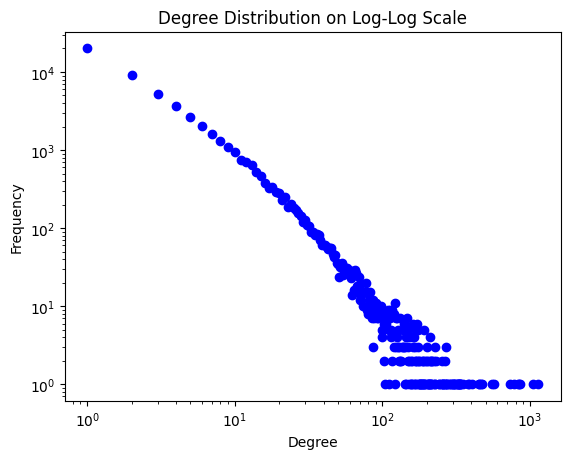

In [ ]:
# Calculate the degrees of all nodes and store them in a list
degrees = [degree for node, degree in G.degree()]

# Count the frequency of each degree value
degree_count = Counter(degrees)
degree, frequency = zip(*degree_count.items())

# Create a scatter plot of degrees (log-log scale)
plt.scatter(degree, frequency, c='blue')

# Set the x and y axis to log scale
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution on Log-Log Scale')

# Show the plot
plt.show()

Power law


In [ ]:
%pip install -q -U powerlaw

Note: you may need to restart the kernel to use updated packages.


Calculating best minimal value for power law fit
2.558853351893055%
459.08354463610004 2.0314625034490142e-14


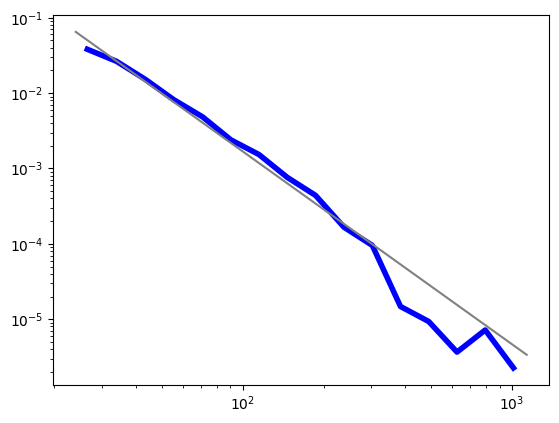

In [17]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
fit = powerlaw.Fit(degree_sequence) 
fig2 = fit.plot_pdf(color='b', linewidth=4)
fit.power_law.plot_pdf(color = "grey", ax=fig2)
print(fit.power_law.alpha)
R, p = fit.distribution_compare('power_law', 'exponential')
print(R, p)

CCDF log log scale


NameError: name 'ax1' is not defined

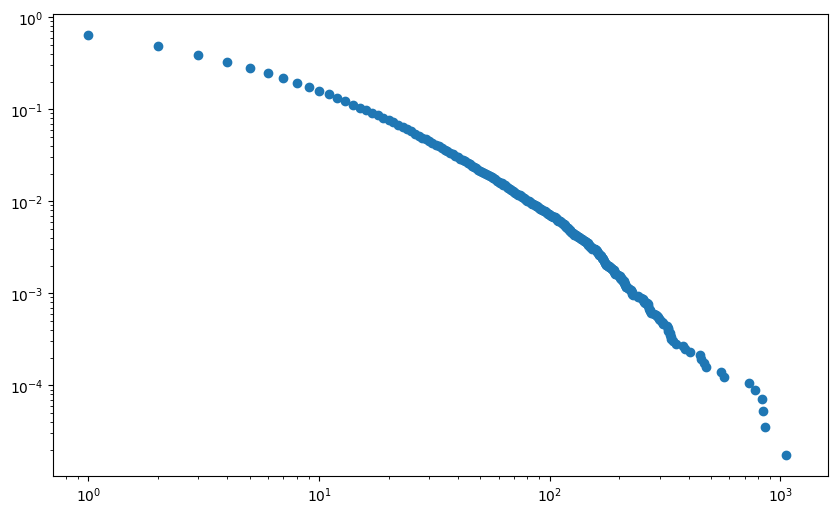

In [18]:
# finding the degree CCDF 
def degree_ccdf(graph):
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    degree, count = zip(*degree_count.items())
    ccdf = 1 - np.cumsum(count[::-1])[::-1]/graph.number_of_nodes()
    return degree, ccdf

# plotting the ccdf for the true graph and the random graph 
degree_G, ccdf_G  = degree_ccdf(G)
plt.figure(figsize=(10, 6))
plt.loglog(degree_G, ccdf_G, marker='o', linestyle='None', label='Network from weighted5.txt')
plt.title('Degree CCDF in Log-Log Scale')
plt.xlabel('Degree')
plt.ylabel('CCDF')
plt.legend()
plt.show()

Density

In [ ]:
density = nx.density(G)
density

0.00013229448579703528

Local clustering coefficient

In [ ]:
def clusters():
    clusters = nx.clustering(G)
    return clusters

clusters = pickle(clusters)
sorted_clusters = sorted(clusters.items(), key=lambda item: item[1], reverse = True)


Found data, loading from picklejar


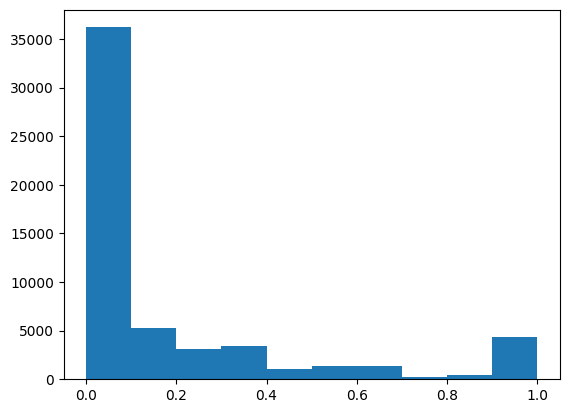

In [ ]:
min(clusters.values()) , max(clusters.values())
# (0,1.0) 
plt.hist(clusters.values())
plt.show()
# most nodes have lower clustering coefficients but some also have very high clustering coefficient 

In [ ]:
avg_LCC = sum(clusters.values())/len(clusters.values())
avg_LCC

0.17337881358774052

In [ ]:
# Transitivity = global clustering coefficient
transitivity = nx.transitivity(G)
transitivity

0.11050982710915977

Diameter

In [ ]:
def diameter():
    diameter = nx.diameter(G)
    return diameter

diameter = pickle(diameter)
# answer = 18 
print(diameter)

Found data, loading from picklejar
18


Average shortest path

In [ ]:
def avg_shortest_path():
    avg_shortest_path = nx.average_shortest_path_length(G)
    return avg_shortest_path
avg_shortest_path = pickle(avg_shortest_path)
avg_shortest_path

# answer: 4.917269741932054

Found data, loading from picklejar


4.917269741932054

Shortest path distribution 

In [ ]:
# Can't run it, I don't have enough memory - Ania


def shortest_path_lengths():
    # Calculate shortest path lengths
    all_shortest_path_lengths = {}

    for node in G.nodes:
        shortest_path_lengths = nx.single_source_shortest_path_length(G, node)
        all_shortest_path_lengths[node] = shortest_path_lengths
    return all_shortest_path_lengths

# Calculate shortest paths lengths for our grapgh and store in a pickle
shortest_path_lengths = pickle(shortest_path_lengths)
print(shortest_path_lengths)

Betweenness centrality

In [ ]:
def betweenness_centrality():
    betweenness_centrality = nx.betweenness_centrality(G)
    return betweenness_centrality
betweenness_centrality = pickle(betweenness_centrality)
betweenness_centrality

Found data, loading from picklejar


{0: 0.0027782250041033085,
 1: 0.00018982797729129089,
 2: 0.0010528766008397162,
 3: 0.009235643798616003,
 4: 0.00014808490951451444,
 5: 0.0004103949944709264,
 6: 0.001906570465119014,
 7: 0.006351480171032358,
 8: 1.0283058986462158e-08,
 9: 0.0002638530413067625,
 10: 0.0007663831030129757,
 11: 0.0009388170519984818,
 12: 0.001290578792613001,
 13: 0.0027401762970616556,
 14: 0.00018472200709877134,
 15: 0.0003178769520871339,
 16: 0.0004148526654272732,
 17: 0.0015359132705463293,
 18: 0.0005376652489143878,
 19: 0.000529870469721093,
 20: 0.0016452755460756858,
 21: 0.0006593984815771676,
 22: 6.928741987384659e-06,
 23: 0.000507492141230547,
 24: 0.0002742208485131949,
 25: 9.903199785339078e-05,
 26: 0.00139962411860137,
 27: 0.005417968494267295,
 28: 0.0002420307629841739,
 29: 0.0029506348828516327,
 30: 0.007011375808041959,
 31: 0.00019186631464922617,
 32: 4.167052190931295e-05,
 33: 0.0,
 34: 0.00034040194583562927,
 35: 0.02498508521877784,
 36: 0.040196157255756634,

Degree distribution dictionary

In [ ]:
def sorted_degree():
    degree_dict = dict(G.degree)
    sorted_degree = (sorted(degree_dict.items(), key=lambda item: item[1], reverse = True))
    return sorted_degree

sorted_degree = pickle(sorted_degree)
print(sorted_degree)

Found data, loading from picklejar
[(40, 1134), (44, 1055), (108, 854), (116, 838), (159, 833), (36, 779), (191, 732), (49, 569), (634, 550), (156, 475), (35, 467), (207, 453), (651, 448), (3245, 404), (250, 386), (2625, 379), (1093, 354), (163, 343), (405, 337), (833, 334), (1100, 333), (27, 332), (212, 327), (112, 326), (6365, 325), (1302, 321), (214, 311), (148, 310), (102, 306), (146, 301), (209, 299), (6991, 296), (1076, 292), (446, 289), (1878, 282), (719, 274), (195, 272), (2812, 271), (176, 270), (1143, 270), (2349, 270), (210, 267), (2896, 267), (1875, 266), (143, 264), (3, 259), (6895, 257), (7170, 256), (30, 254), (676, 253), (2904, 253), (2850, 248), (680, 242), (241, 241), (7, 230), (10346, 230), (174, 228), (1082, 228), (2829, 228), (1386, 227), (1877, 226), (2953, 225), (6923, 225), (2893, 221), (620, 218), (2314, 218), (901, 215), (262, 214), (2880, 214), (6640, 213), (13909, 213), (6589, 212), (301, 211), (144, 210), (161, 210), (229, 210), (1876, 210), (168, 209), (18